# Neural Networks for EEG Decoding

Data
*   2558 trials available. Each trial contains 4 seconds of 22 channel EEG data from 1 of 9 total subjects who are imagining 1 of 4 movements. Sampled at 250 Hz. Sourced from http://www.bbci.de/competition/iv/ with preprocessing.

Models
*   4 neural networks were made: an RNN, CRNN, a CNN designed for use with images, and a CNN designed for EEG data. The models are stored in ```eeg_models.py```


###Google Drive and GPU Prep
In Google Colab select Runtime -> Change Runtime Type -> Hardware Accelerator: GPU

In [6]:
#Ensure tensorflow-gpu is installed
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 47kB/s 


In [7]:

%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
/device:GPU:0
Num GPUs Available:  1


In [8]:
from google.colab import drive
drive.mount('/content/drive/')#Will need to sign in and authorize

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Create a new folder, install Git-LFS, and clone the Github repository
Change ```my_gdrive_path``` as desired


In [9]:
from os.path import join
root = '/content/drive'
%cd "{root}"
my_gdrive_path = 'My Drive/Neural-Networks-EEG-Decoding'#change accordingly, should be an empty directory
project_path = join(root,my_gdrive_path)
#This will create a new directory
!mkdir "{project_path}"

git_path = "https://github.com/kkapre/Neural-Networks-EEG-Decoding.git"
%cd "{project_path}"

/content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/Neural-Networks-EEG-Decoding’: File exists
/content/drive/My Drive/Neural-Networks-EEG-Decoding


In [10]:
#Github Large File Storage (LFS) is used by repository and needs to be downloaded to properly clone it
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,515 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 144793 files and directories c

In [11]:
#This will copy over the github project into the new directory (should be empty)
!git clone "{git_path}" . #clone into an empty directory

fatal: destination path '.' already exists and is not an empty directory.


In [12]:
!git checkout main
%ls

Already on 'main'
Your branch is up to date with 'origin/main'.
fatal: cannot exec '.git/hooks/post-checkout': Permission denied
data/          models/                NN_EEG_Paper.pdf
eeg_models.py  NN_EEG_Decoding.ipynb  README.md


### Data Prep
Data should be stored in a folder on the mounted google drive

In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import itertools
from sklearn.metrics import confusion_matrix
import importlib

import eeg_models
importlib.reload(eeg_models)#update models in case file changed
from eeg_models import RNN,Image_CNN,CRNN,EEG_CNN

#Load EEG data
#Dimensions are (Recordings,channels,time bins)
x_train= np.load("data/x_train.npy")
x_test = np.load("data/x_test.npy")
x_val = np.load("data/x_val.npy")

#Load one-hot encoded labels
y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")
y_val = np.load("data/y_val.npy")

#Subject id corresponding to each recording
person_train = np.load("data/person_train.npy")
person_test = np.load("data/person_test.npy")
person_val = np.load("data/person_val.npy")


#Segment Data

#samples taken at 250Hz, full data is 4s long or 1000 bins
num_bins = 300 #Accuracy maintained with minimum of 300 bins
#uncomment if testing on lower number of bins
#num_bins = np.shape(data['X_train'])[2] #Use all bins
x_train = x_train[:,0:num_bins,:]
x_test = x_test[:,0:num_bins,:]
x_val = x_val[:,0:num_bins,:]


#Store in dict, for organization and printing
data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_val':x_val,
    'y_val':y_val,
    'x_test':x_test,
    'y_test':y_test,
    'person_train': person_train,
    'person_test': person_test,
    'person_val': person_val,
}
#Print and check dimensions
for k in data.keys():
    print('{}: {}'.format(k,data[k].shape))

x_train: (1903, 300, 22)
y_train: (1903, 4)
x_val: (212, 300, 22)
y_val: (212, 4)
x_test: (443, 300, 22)
y_test: (443, 4)
person_train: (1903,)
person_test: (443,)
person_val: (212,)


### Choose to train on all subjects, or a specific subject

In [14]:
use_subj = 0#set to 1 if training on only 1 subject
if(use_subj):
  subj = 0#choose which subject to train on
  
  print(f"Using subject {subj}")
  idxs = np.nonzero(person_train==subj)
  x_train,y_train = data['x_train'][idxs],data['y_train'][idxs]
  idxs = np.nonzero(person_val==subj)
  x_val,y_val = data['x_val'][idxs],data['y_val'][idxs]
  idxs = np.nonzero(person_test==subj)
  idxs_gen = np.nonzero(person_test!=subj)
  x_gen,y_gen = data['x_test'][idxs_gen],data['y_test'][idxs_gen]#store data from other subjects to test generalizability
  x_test,y_test = data['x_test'][idxs],data['y_test'][idxs]

  data_adj = {
      'x_train':x_train,
      'y_train':y_train,
      'x_val':x_val,
      'y_val':y_val,
      'x_test':x_test,
      'y_test':y_test,
      'x_gen': x_gen,
      'y_gen': y_gen,
  }
  for k in data_adj.keys():#view new data
      print('{}: {}'.format(k,data_adj[k].shape))


else:
  #reset data to all subjects if it was changed
  x_train = data['x_train']
  y_train = data['y_train']
  x_val = data['x_val']
  y_val = data['y_val']
  x_test = data['x_test']
  y_test = data['y_test']

  for k in data.keys():#view data
      print('{}: {}'.format(k,data[k].shape))
  print("Using All Subjects")

x_train: (1903, 300, 22)
y_train: (1903, 4)
x_val: (212, 300, 22)
y_val: (212, 4)
x_test: (443, 300, 22)
y_test: (443, 4)
person_train: (1903,)
person_test: (443,)
person_val: (212,)
Using All Subjects


###Neural Network Training

*   Model is imported from `eeg_models.py` file
*   Flow Diagram illustrates shape
*  Model is trained using a learning rate schedule of 20 epochs with a learning rate of $10^{-3}$ and another 20 epochs with a learning rate of $10^{-4}$




In [15]:
#Leave a single model uncommented to use it
importlib.reload(eeg_models)
from eeg_models import RNN,Image_CNN,EEG_CNN,CRNN

#model= Image_CNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,filter_size=[3,3],num_filter=[50,100])
#model= RNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,lstm_units=100)
model= EEG_CNN(num_classes=4,input_dim=(num_bins,22),num_filter=[50,100],dropout=0.5,filter_size=[22,75])
#model= CRNN(num_classes=4,input_dim=(num_bins,22),dropout=0.5,num_filter=100,filter_size=22)
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 22)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 300, 22, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 1, 50)        1150      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 226, 1, 100)       375100    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 1, 100)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 1, 100)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 1, 100)       

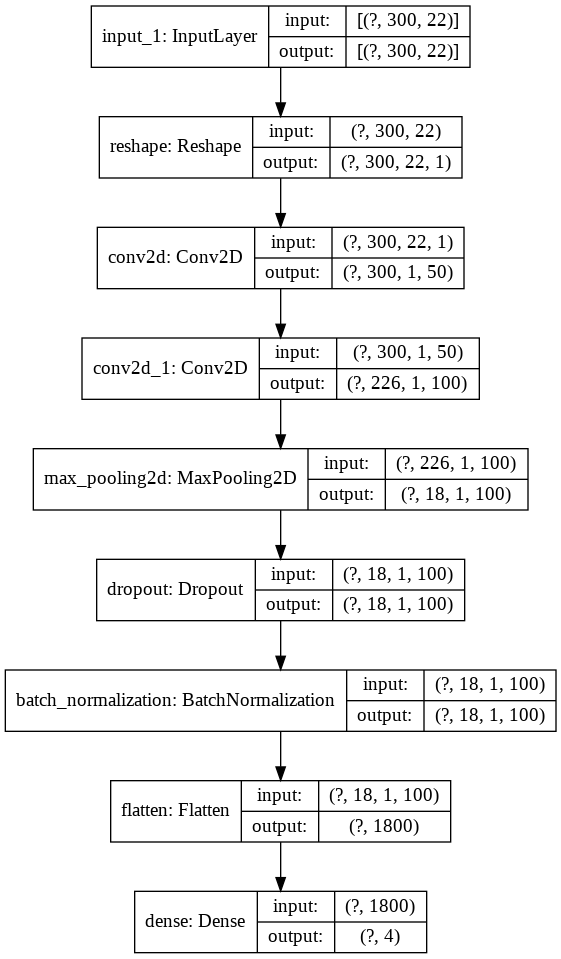

In [16]:
#get flow diagram
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [17]:
#first training run
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics = ['categorical_accuracy'])
history = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_val,y_val),verbose=True)


Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 1.8092 - categorical_accuracy: 0.3232 - val_loss: 2.4949 - val_categorical_accuracy: 0.3443
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 1.4664 - categorical_accuracy: 0.4435 - val_loss: 1.3405 - val_categorical_accuracy: 0.4811
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 1.2377 - categorical_accuracy: 0.5355 - val_loss: 1.1677 - val_categorical_accuracy: 0.5472
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 1.1006 - categorical_accuracy: 0.6001 - val_loss: 1.1465 - val_categorical_accuracy: 0.5660
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.9556 - categorical_accuracy: 0.6532 - val_loss: 1.0740 - val_categorical_accuracy: 0.6085
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.8920 - categorical_accuracy: 0.6805 - val_loss: 1.0482 - val_categorical_accuracy: 0.5991
Epoch 7/20
30/3

In [18]:
#second training run
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics = ['categorical_accuracy'])
history2 = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_val,y_val),verbose=True)


Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3128 - categorical_accuracy: 0.9606 - val_loss: 0.9776 - val_categorical_accuracy: 0.6934
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2760 - categorical_accuracy: 0.9764 - val_loss: 0.9777 - val_categorical_accuracy: 0.6887
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2622 - categorical_accuracy: 0.9827 - val_loss: 1.0113 - val_categorical_accuracy: 0.6887
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2514 - categorical_accuracy: 0.9874 - val_loss: 1.0094 - val_categorical_accuracy: 0.6745
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2457 - categorical_accuracy: 0.9874 - val_loss: 0.9978 - val_categorical_accuracy: 0.6887
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2328 - categorical_accuracy: 0.9890 - val_loss: 1.0102 - val_categorical_accuracy: 0.6840
Epoch 7/20
30/3

## Evaluate Model


*   Get loss and accuracy for test sest. Get generalizability by testing on other subjects, if only one subject was used in training.
*   Plot accuracy and loss vs epochs for training and validation set. 
*   Visualize confusion matrix



In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} \nTest accuracy: {score[1]}')
test_acc = int(score[1]*100)

if(use_subj): #if trained on only one subject
  score_gen = model.evaluate(x_gen, y_gen, verbose=0)#evaluate on other subjects
  print(f'Generalization Test loss: {score_gen[0]} \nGeneralization Test accuracy: {score_gen[1]}')
  gen_acc = int(score_gen[1]*100)

Test loss: 0.9569534659385681 
Test accuracy: 0.7133182883262634


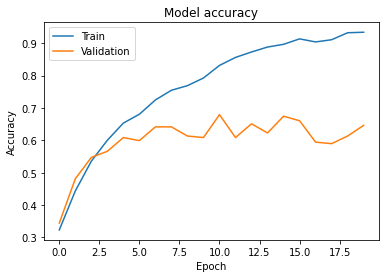

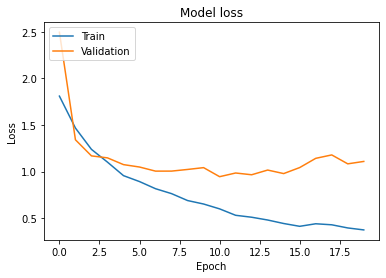

In [20]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


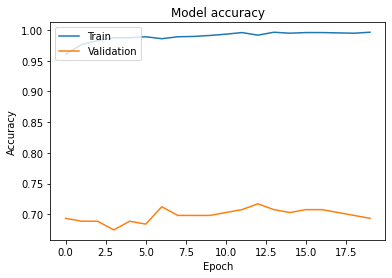

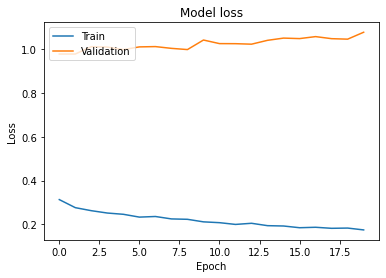

In [21]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


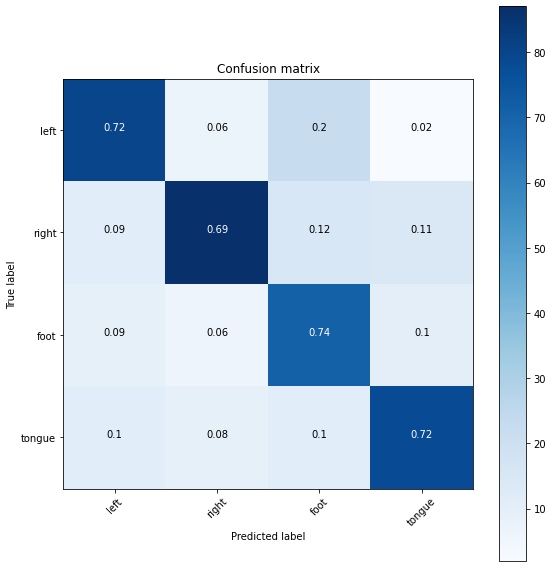

In [22]:
#plot_confusion_matrix code from https://www.tensorflow.org/tensorboard/image_summaries
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

y_pred = model.predict(x_test)
y_pred_num = np.argmax(y_pred,axis=1)
y_test_num = np.argmax(y_test,axis=1)
test_acc_num = np.mean(y_pred_num==y_test_num)
cm = confusion_matrix(y_test_num,y_pred_num)
class_labels = ['left','right','foot','tongue']
x =plot_confusion_matrix(cm,class_labels)


### Save model

In [24]:
#Save model, change name accordingly
!mkdir "{project_path}/models"
path = f'{project_path}/models/model_{test_acc}acc_{num_bins}bins'
model.save(path)

mkdir: cannot create directory ‘/content/drive/My Drive/Neural-Networks-EEG-Decoding/models’: File exists
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural-Networks-EEG-Decoding/models/model_71acc_300bins/assets
